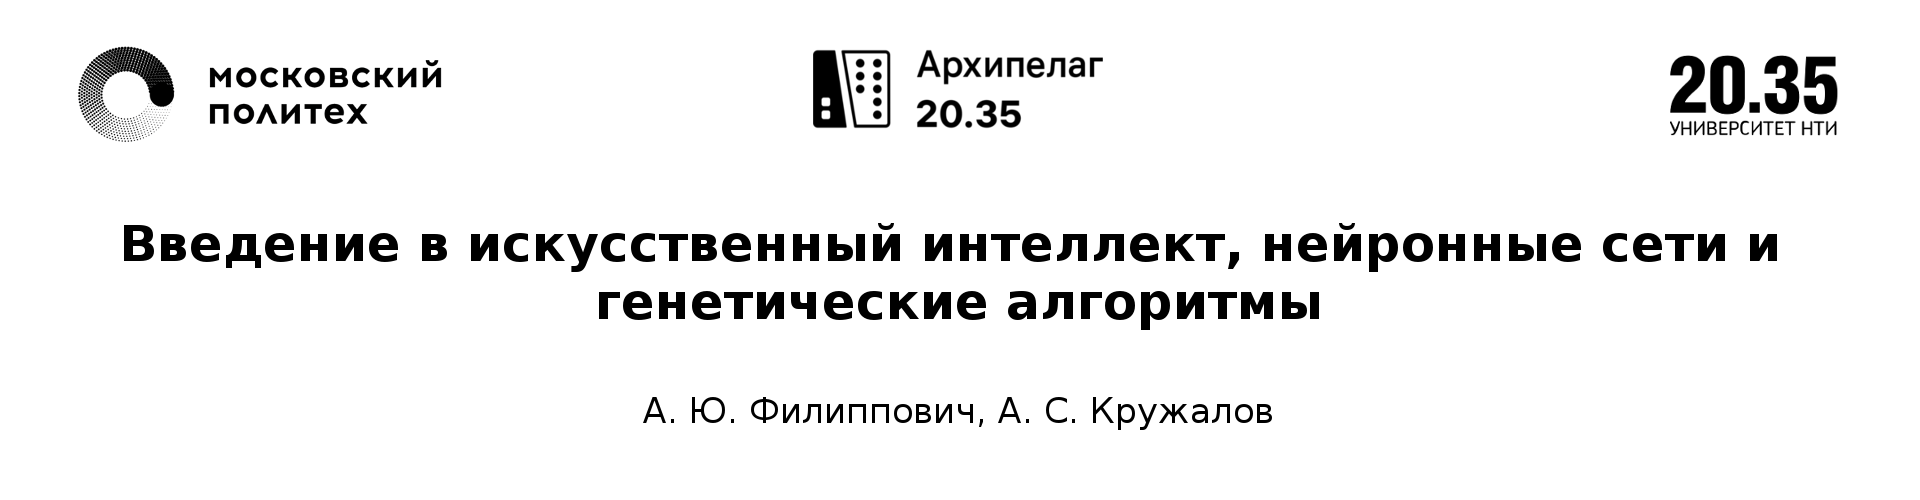

# **Распознавание рукописных цифр при помощи многослойного персептрона**

<a href="mailto:alexkruzhalov@gmail.com">Кружалов А. С.</a> | Leader-ID: `#955144#`

**12 ноября 2020 г.**



В данной работе вам предстоит изучить возможности многослойного персептрона и обучить его распознавать рукописные цифры из набора данных MNIST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_circles
from tqdm import tqdm

## Часть 1. Исследование возможностей многослойного персептрона

Главным преимуществом многослойного персептрона является его способность моделировать нелинейные зависимости. В данном разделе вам нужно решить задачу бинарной классификации для случая, когда данные не являются линейно разделимыми.

In [2]:
X, y = make_circles(n_samples=500, random_state=9, noise=0.1, factor=0.2)

In [3]:
X = (X - X.mean(axis=0))/X.std(axis=0)

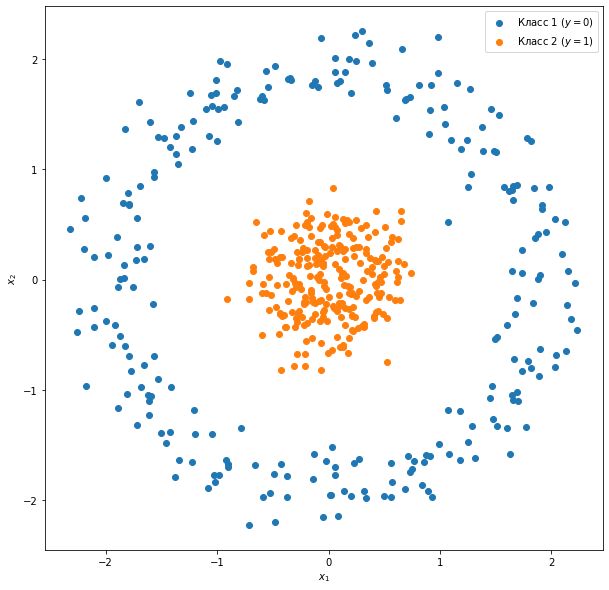

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Класс 1 ($y = 0$)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Класс 2 ($y = 1$)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

Ниже представлена заготовка класса персептрона. Реализуйте недостающие части.

In [5]:
class MultilayerPerceptron:
    def __init__(self, m, h, k, learning_rate=0.001, num_epochs=20, verbose=False):
        self.m = m # number of features
        self.h = h # number of neurons in hidden layer
        self.k = k # number of classes (neurons in output layer)
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.verbose = verbose
        self._validation_freq = 1
        self._init_params()
    
    # Initialize weights and biases
    def _init_params(self):
        # Weights and biases for hidden layer
        self.w1 = np.random.normal(0, 0.1, (self.m, self.h))
        self.b1 = np.random.normal(0, 0.1, (1, self.h))
        # Weights and biases for output layer
        self.w2 = np.random.normal(0, 0.1, (self.h, self.k))
        self.b2 = np.random.normal(0, 0.1, (1, self.k))
        
    # Sigmoid function
    def _activate(self, x):
        return 1/(1 + np.exp(-x))

    # Loss function derivative 
    def _loss_derivative(self, y, y_pred):
        return (y_pred - y)

    # Activation function derivative
    def _activate_derivative(self, output):
        return output*(1 - output)
    
    # Predict class labels for samples in X (zero or one).
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) > threshold).astype(np.uint8)
    
    # Forward pass
    def predict_proba(self, X):
        self.hidden_outputs = self._activate(X @ self.w1 + self.b1)
        X = self._activate(self.hidden_outputs @ self.w2 + self.b2)
        return X

    # Calculate gradient using backpropagation
    def _backward_pass(self, X, y, y_pred):
        # Compute delta for output layer
        # Hint: use _loss_derivative and _activate_derivative
        delta_w2 = self._loss_derivative(y, y_pred)*self._activate_derivative(y_pred)

        # Compute gradient for output layer
        # Hint: use hidden_outputs and delta_w2
        self.grad_w2 = self.hidden_outputs.T @ delta_w2
        self.grad_b2 = delta_w2

        # Compute delta for hidden layer
        # Hint: use _activate_derivative, delta_w2 and w2
        delta_w1 = self._activate_derivative(self.hidden_outputs)*(delta_w2 @ self.w2.T)

        # Compute gradient for hidden layer
        # Hint: use X and delta_w2
        self.grad_w1 = X.T @ delta_w1
        self.grad_b1 = delta_w1

    # Use gradient descent rule to update parameters
    def _update_params(self):
        self.w1 -= self.learning_rate*self.grad_w1
        self.w2 -= self.learning_rate*self.grad_w2
        self.b1 -= self.learning_rate*self.grad_b1
        self.b2 -= self.learning_rate*self.grad_b2

    # Compute accuracy
    def _accuracy(self, y_test, y_test_pred):
        if self.k > 1:   
          # For multiclass classification
          accuracy = (y_test.argmax(axis=1) == y_test_pred.argmax(axis=1)).mean()
        else:
          # For binary classification
          accuracy = (y_test == (y_test_pred > 0.5).astype(np.uint8).squeeze()).mean()
        return accuracy
    
    # Compute MSE loss
    # Note: more appropriate loss function for classification task is cross-entropy loss, 
    # but we use MSE for simplicity.
    def _loss(self, y_test, y_test_pred):
        if self.k > 1:
          # For multiclass classification
          loss = (0.5*(y_test - y_test_pred)**2).sum(axis=1).mean()
        else:
          # For binary classification
          loss = (0.5*(y_test - y_test_pred.squeeze())**2).mean()
        return loss
        
    def fit(self, X, y, X_test=None, y_test=None):
        losses = []
        for i in tqdm(range(self.num_epochs)):
            for j in range(X.shape[0]):
                # Compute prediction for X[j]
                y_pred = self.predict_proba(X[j].reshape(1, -1))
                self._backward_pass(X[j].reshape(1, -1), y[j].reshape(1, -1), y_pred)
                self._update_params()

            if X_test is not None and y_test is not None:
                # Compute predictions for test set and compute accuracy
                y_test_pred = self.predict_proba(X_test)
                loss = self._loss(y_test, y_test_pred)
                losses.append(loss)
                
                if self.verbose and (i + 1) % self._validation_freq == 0:
                    accuracy = self._accuracy(y_test, y_test_pred)
                    print("Accuracy on {}-th epoch is {:.04f}".format(i+1, accuracy))

        return losses

Обучите персептрон на данных, сгенерированных выше. Постройте график зависимости значения функции ошибки от номера эпохи.

In [9]:
perceptron = MultilayerPerceptron(2, 3, 1, learning_rate=0.1, num_epochs=150, verbose=False)
losses = perceptron.fit(X, y, X_test=X, y_test=y)

100%|██████████| 150/150 [00:03<00:00, 47.41it/s]


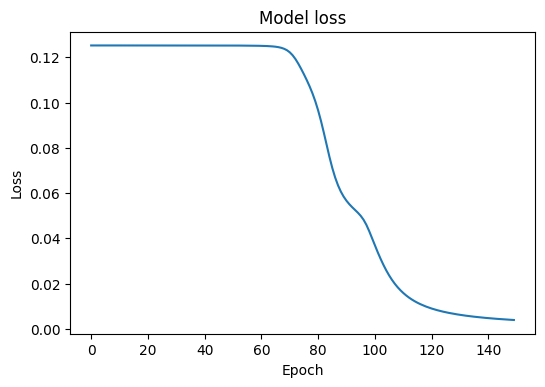

In [10]:
plt.figure(dpi=100)
plt.plot(losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Постройте график, показывающей форму границы решения (англ. decision boundary).

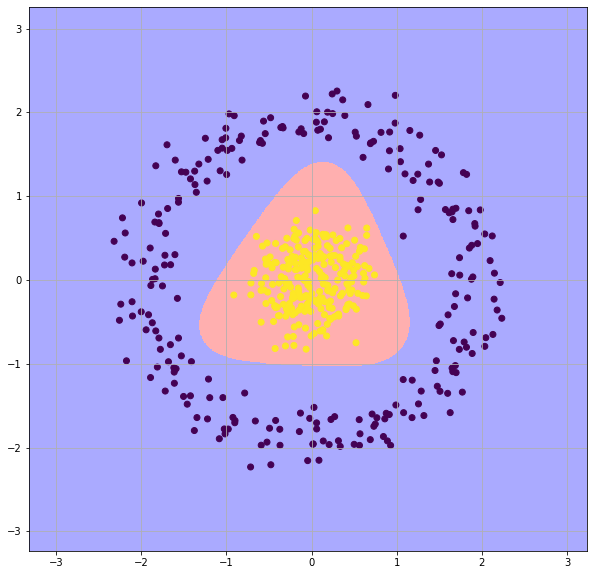

In [11]:
fig = plt.figure(figsize=(10, 10))
xx, yy = np.meshgrid(np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000), np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000))
pred = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)
plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=y)

plt.show()

Постройте графики, показывающие форму границы решения (англ. decision boundary) для нейронов скрытого слоя.

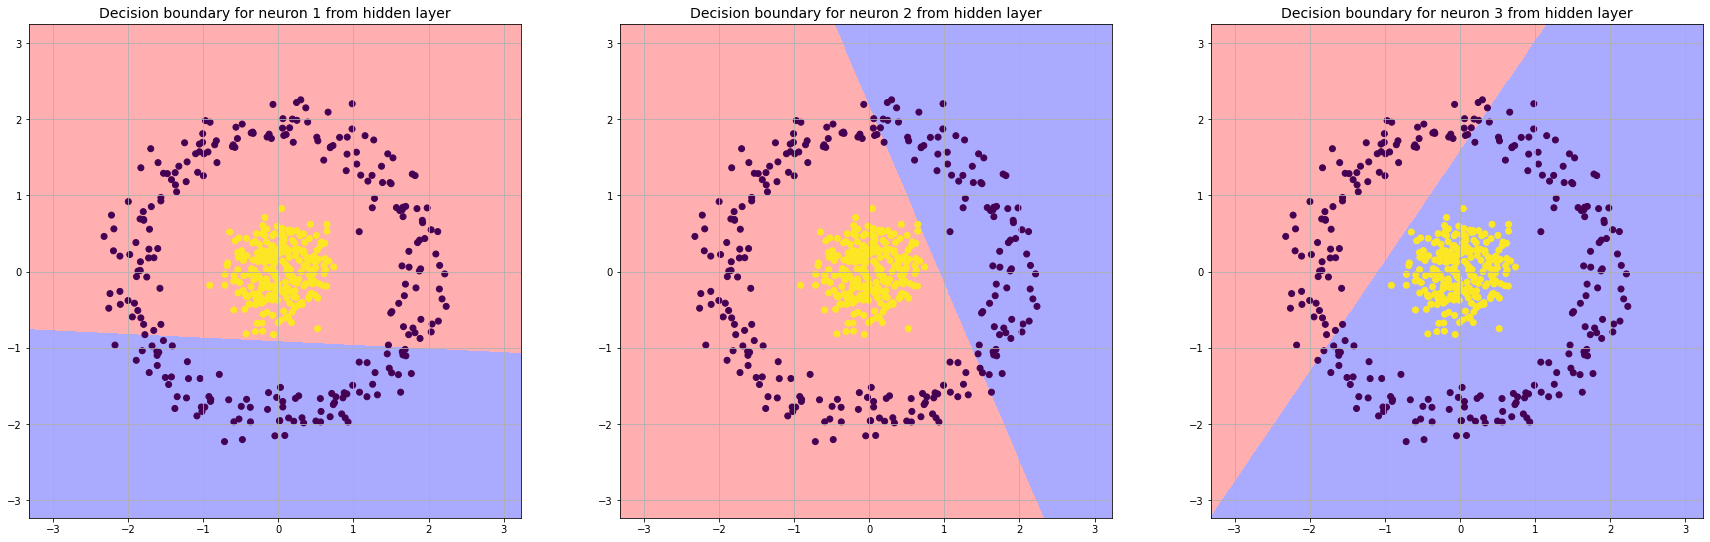

In [12]:
xx, yy = np.meshgrid(np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000), np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000))
pred = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
columns=3 
rows=2
amount = min(columns*rows, perceptron.hidden_outputs.shape[1])
fig=plt.figure(figsize=(10*columns, 10*rows))
for i in range(amount):
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Decision boundary for neuron {i+1} from hidden layer', fontsize=14)
    neuron_pred = perceptron.hidden_outputs[:,i].reshape(xx.shape)
    plt.pcolormesh(xx, yy, neuron_pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))
    plt.grid()
    plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

На основе проведённых экспериментов определите, какое минимальное число нейронов должно быть в скрытом слое, чтобы можно было безошибочно решить данную задачу? Ответ обоснуйте.

**Ответ:**

## Часть 2. Распознавание рукописных цифр

Обучите реализованный в прошлом разделе многослойный персептрон распознавать рукописные цифры из набора данных MNIST.

In [13]:
def plot_images(images, titles, columns=5, rows=1, fontsize=20):
    fig=plt.figure(figsize=(20, 10))
    for i, img in enumerate(images[:columns*rows]):
        fig.add_subplot(rows, columns, i + 1)
        plt.axis('off')
        plt.title(titles[i], fontsize=fontsize)
        plt.imshow(img, cmap='gray')
    plt.show()

In [14]:
(X_train_original, y_train), (X_test_original, y_test) = mnist.load_data()
print(X_train_original.shape, X_test_original.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


Закодируйте метки классов в виде векторов с помощью one-hot encoding.

*Подсказка: для решения этой задачи удобно использовать функцию `np.eye`.*

In [16]:
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

Выполните предобработку данных изображений, чтобы значение каждого пикселя принадлежало множеству $\{0, 1\}$.

In [17]:
X_train = np.array(X_train_original/255 > 0.5, dtype=np.int16)
X_test = np.array(X_test_original/255 > 0.5, dtype=np.int16)

Обучите персептрон. Перед подачей изображений на вход персептрону, преобразуйте их в вектора размерности 784. Подберите подходящее значение параметра learning_rate.

*Подсказка: для изменения формы массива можно воспользоваться методом `reshape`.*

In [18]:
perceptron = MultilayerPerceptron(784, 100, 10, learning_rate=0.01, num_epochs=10, verbose=True)
losses = perceptron.fit(X_train.reshape(-1, 784), y_train_one_hot, X_test=X_test.reshape(-1, 784), y_test=y_test_one_hot)

 10%|█         | 1/10 [00:50<07:33, 50.41s/it]

Accuracy on 1-th epoch is 0.8826


 20%|██        | 2/10 [01:40<06:43, 50.45s/it]

Accuracy on 2-th epoch is 0.9039


 30%|███       | 3/10 [02:31<05:52, 50.35s/it]

Accuracy on 3-th epoch is 0.9151


 40%|████      | 4/10 [03:26<05:11, 51.96s/it]

Accuracy on 4-th epoch is 0.9223


 50%|█████     | 5/10 [04:17<04:17, 51.48s/it]

Accuracy on 5-th epoch is 0.9285


 60%|██████    | 6/10 [05:06<03:23, 50.94s/it]

Accuracy on 6-th epoch is 0.9321


 70%|███████   | 7/10 [05:56<02:32, 50.68s/it]

Accuracy on 7-th epoch is 0.9355


 80%|████████  | 8/10 [06:46<01:40, 50.43s/it]

Accuracy on 8-th epoch is 0.9389


 90%|█████████ | 9/10 [07:36<00:50, 50.35s/it]

Accuracy on 9-th epoch is 0.9424


100%|██████████| 10/10 [08:26<00:00, 50.69s/it]

Accuracy on 10-th epoch is 0.9444


 Постройте график зависимости значения функции ошибки от номера эпохи.

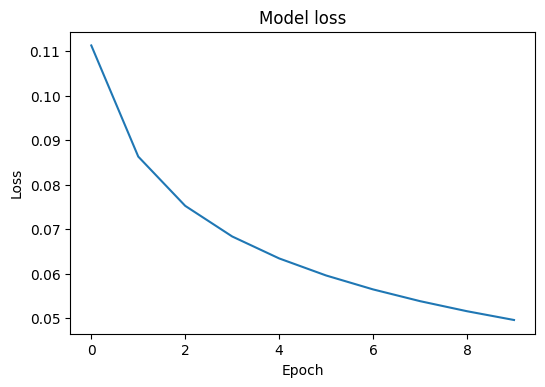

In [19]:
plt.figure(dpi=100)
plt.plot(losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Вычислите предсказания для тестовой выборки.

*Подсказка: чтобы из one-hot encoding вернуться к десятичным цифрам, можно воспользоваться методом `argmax`.*

In [20]:
y_test_pred = perceptron.predict_proba(X_test.reshape(-1, 784)).argmax(axis=1)

Выведите первые пять изображений из тестовой выборки. В качестве заголовка к каждому изображению выведите ожидаемую (англ. expected) и предсказанную (англ. predicted) метки класса.

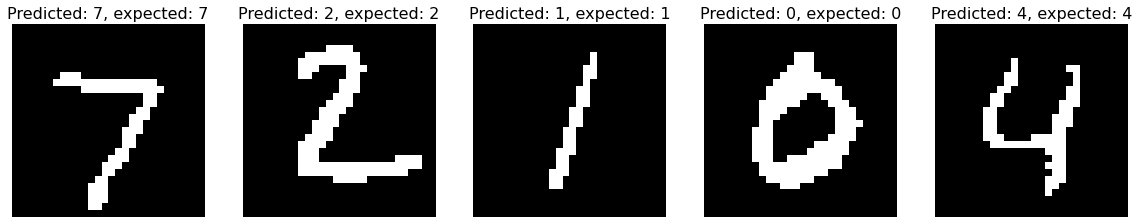

In [21]:
columns = 5
rows = 1
titles = ["Predicted: {}, expected: {}".format(y_test_pred[i], y_test[i]) for i in range(columns*rows)]
plot_images(X_test, titles, columns=columns, rows=rows, fontsize=16)

Выведите несколько изображений из тестовой выборки, в которых персептрон допустил ошибку. В качестве заголовка к каждому изображению выведите ожидаемую (англ. expected) и предсказанную (англ. predicted) метки класса. Как вы считаете, есть ли в допущенных ошибках какая-то закономерность? Отличаются ли эти ошибки от тех, которые допустил однослойный персептрон?


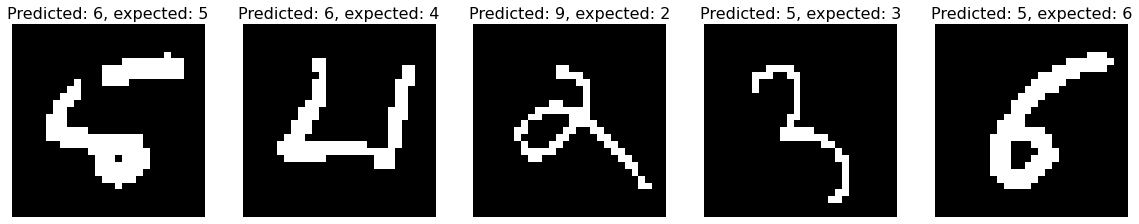

In [22]:
columns = 5
rows = 1
e_mask = y_test_pred != y_test # mask of errors
titles = ["Predicted: {}, expected: {}".format(y_test_pred[e_mask][i], y_test[e_mask][i]) for i in range(columns*rows)]
plot_images(X_test[e_mask], titles, columns=columns, rows=rows, fontsize=16)

**Ответ:**

Постройте матрицу ошибок (англ. confusion matrix) для полученной нейронной сети. 

Подсказка: можно воспользоваться функцией [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/0.16/modules/generated/sklearn.metrics.confusion_matrix.html). [Пример матрицы ошибок.](https://ml4a.github.io/demos/confusion_mnist/)

In [23]:
cm = confusion_matrix(y_test, y_test_pred)
# Normalize confusion matrix:
cm = cm/cm.sum(axis=1).reshape(-1, 1)

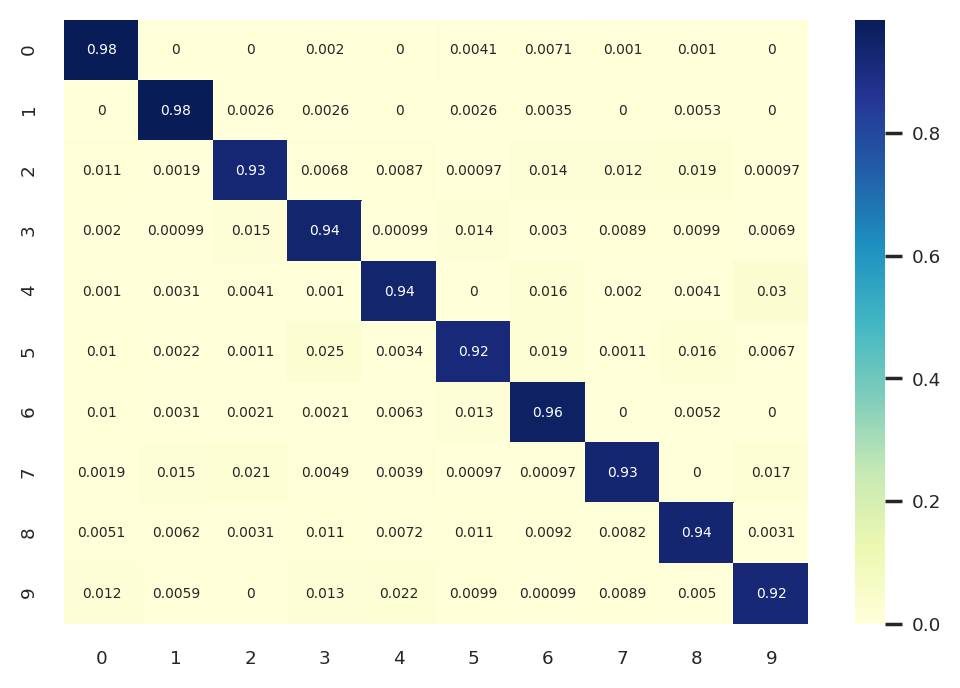

In [24]:
plt.figure(dpi=200)
sns.set(font_scale=0.6)
g = sns.heatmap(cm, annot=True, annot_kws={"size": 5}, cmap="YlGnBu")
plt.show()

Сравните полученную точность распознавания с аналогичным значением, полученным для однослойного персептрона. Прокомментируйте полученный результат.

**Ответ:**

### Полезные материалы
1. [Looking inside neural nets](https://ml4a.github.io/ml4a/looking_inside_neural_nets/)
2. [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
3. Christopher Bishop [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/) (Chapter 5 «Neural networks»).
4. Уоссермен Ф. – Нейрокомпьютерная техника : Теория и практика // Издательство: Мир, 1992 – 240 с. (Глава 3 «Процедура обратного распространения»)